## Microsoft Building Footprints Example

Bing Maps is releasing open building footprints around the world. The building footprints are detected using Bing Maps imagery between 2014 and 2021 including Maxar and Airbus imagery. The data is freely available for download and use under ODbL.

In [1]:
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas
import dask.distributed
import deltalake
import shapely.geometry
import contextily
import mercantile

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) to get a link to the assets. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

### Using Delta Table Files

The assets are a set of [geoparquet](https://geoparquet.org/) files grouped by a processing date. Newer files (since April 25th, 2023) are stored in [Delta Format](https://docs.delta.io/latest/delta-intro.html). This is a layer on top of parquet files offering scalable metadata handling, which is useful for this dataset.

In [3]:
asset = collection.assets["delta"]

This Delta Table is partitioned by `RegionName` and `quadkey`. Each `(RegionName, quadkey)` pair will contain one or more parquet files (depending on how dense that particular quadkey) is. The quadkeys are at level 9 of the [Bing Maps Tile System](https://learn.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system).

In [4]:
storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

You can load all the files for a given `RegionName` with a query like this:

In [5]:
file_uris = table.file_uris([("RegionName", "=", "VaticanCity")])

df = dask_geopandas.read_parquet(file_uris, storage_options=storage_options)
df

,geometry,meanHeight,RegionName,quadkey
npartitions=1,,,,
,geometry,float32,category[known],category[known]
,...,...,...,...


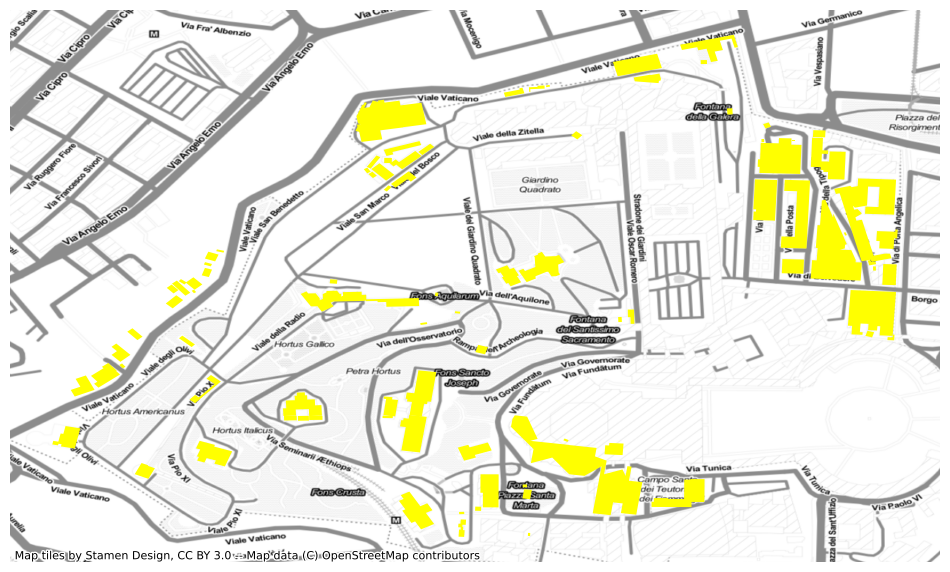

In [6]:
ax = df.compute().plot(figsize=(12, 12), color="yellow")
contextily.add_basemap(
    ax, source=contextily.providers.Stamen.TonerLite, crs=df.crs.to_string()
)
ax.set_axis_off()

This partitioning, and the Delta Table format, let you quickly query the subset of files that match your area of interest.

For example, we can visualize the footprints for a small region outside the town of Ueckermünde in Northeast Germany defined by this bounding box.

In [7]:
area_of_interest = shapely.geometry.box(14.11, 53.73, 14.13, 53.75)

You will need to translate your area of interest to a set of intersecting quadkeys, which can be done with [mercantile](https://mercantile.readthedocs.io/en/stable/).

In [8]:
quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*area_of_interest.bounds, zooms=9)
]
quadkeys

[120210300, 120210302]

Now we can provide those quadkeys as a partition filter to get the set of matching URIs.

In [9]:
uris = table.file_uris([("RegionName", "=", "Germany"), ("quadkey", "in", quadkeys)])
uris

['az://footprints/delta/2023-04-25/ml-buildings.parquet/RegionName=Germany/quadkey=120210300/part-00168-a20a8489-66de-4ede-be14-48423c230226.c000.snappy.parquet',
 'az://footprints/delta/2023-04-25/ml-buildings.parquet/RegionName=Germany/quadkey=120210302/part-00197-b547555b-9f9e-4cf2-8016-b35087e71f2b.c000.snappy.parquet']

And quickly load them into, for example, a dask-geopandas `GeoDataFrame`:

In [10]:
df = dask_geopandas.read_parquet(uris, storage_options=storage_options)
df

,geometry,meanHeight,RegionName,quadkey
npartitions=2,,,,
,geometry,float32,category[known],category[known]
,...,...,...,...
,...,...,...,...


Which can be visualized:

In [11]:
subset = df.clip(area_of_interest).compute()
subset.explore()

### Using the STAC API

As an alternative to Delta, you can use the Planetary Computer STAC API to query files matching your area of interest.

In [12]:
search = catalog.search(
    collections=["ms-buildings"],
    intersects=area_of_interest,
    query={
        "msbuildings:region": {"eq": "Germany"},
        "msbuildings:processing-date": {"eq": "2023-04-25"},
    },
)

ic = search.get_all_items()
len(ic)

2

See the summaries on the collection for a list of valid processing dates.

Once you have the items, you can load them into a `GeoDataFrame`. Note that each `data` asset has one or more parquet files under it, so we need to do two levels of concatentation.

In [13]:
prefixes = [item.assets["data"].href for item in ic]
df = dask.dataframe.concat(
    [
        dask_geopandas.read_parquet(prefix, storage_options=storage_options)
        for prefix in prefixes
    ]
)
df.head()

,geometry,meanHeight,RegionName,quadkey
0,"POLYGON ((14.23111 53.66713, 14.23120 53.66714...",-1.0,Germany,120210302
1,"POLYGON ((14.13342 53.53018, 14.13337 53.53030...",-1.0,Germany,120210302
2,"POLYGON ((14.34231 53.33267, 14.34236 53.33258...",-1.0,Germany,120210302
3,"POLYGON ((14.09257 53.49413, 14.09274 53.49409...",-1.0,Germany,120210302
4,"POLYGON ((14.07604 53.68923, 14.07603 53.68927...",-1.0,Germany,120210302


### Next steps

This example briefly demonstrated searching the STAC catalog and loading the data with geopandas. To learn more, visit the following resources:

* Learn more about [geopandas](https://geopandas.readthedocs.io).
* Learn more about [Dask](https://dask.org/)
* Learn more about [geoparquet](https://github.com/opengeospatial/geoparquet)
* Learn more about the [Global MLBuildings Footprints](https://github.com/microsoft/GlobalMLBuildingFootprints/) project.